# Performance
This notebook will provide a set of general aircraft performance metrics. These are useful for determinine several different performance parameters that are useful for high-level design decisions.

The user must provide:
 - Environmental properties (e.g. air density, etc.)
 - Aircraft parameters (e.g. weight, wing area, etc.)
 - Propulsion parameters (e.g. power, specific power, etc.)
 
The outputs of this program include
 - Stall speeds
 - Lift to drag ratios vs. airspeed
 - Thrust required vs. airspeed
 - Power required vs. airspeed
 - Climb rate vs. airspeed for various power settings
 - Fuel comsumption vs. airspeed
 - Specific range vs. airspeed
 
Once the parameters are provided simply run all the cells of the notebook and the outputs will be generated as plots and saved in the plots folder.

Load some useful Libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

Specify the environmental, aircraft, and propulsion parameters

In [2]:
# Environmental Parameters
rho_0 = 1.22  # Air density at sea level (kg/m^3)
rho = 0.9093  # Air density at current altitude (kg/m^3)
g = 9.81  # Acceleration due to gravity (m/s^2)

# Aircraft Parameters (Cessna 172)
m = 1000  # Aircraft mass (kg)
s_w = 16.2  # Wing area (m^2)
c_d0 = 0.035  # Parasitic drag coefficient
c_d0l = 0  # Linear drag coefficient term (typically 0)
e = 0.7  # Oswald efficiency factor
ar = 7.32  # Wing aspect ratio
c_lmax_nf = 1.6  # Maximum lift coefficient with no flaps
c_lmin_nf = -1.3  # Minimum lift coefficient without flaps
c_lmax_f = 2.1  # Maximum lift coefficient with flaps
n_pll = 3.8  # Maximum design g-loading
n_nll = -1.5  # Minimum design g-loading

# Propulsion Parameters
p_a0 = 119000  # Engine power at sea level (W)
q_p = 8.5E-7  # Specific power fuel consumption ((N/s)/W)
alpha_t = 0.08172675000993017  # Offset between thrust and angle of attack (radians)

Pre-calculate the aircraft weight

In [3]:
# Pre-calculations
w = m * g  # Aircraft weight (N)

Define the stall speed function

In [4]:
def stall_speeds(w, s_w, rho, c_lmax_nf, c_lmax_f):
    # Computes the aircraft stall speeds with and without flaps

    # Equation 3.8.3 of Phillips
    v_min_nf = math.sqrt(2 / c_lmax_nf) * math.sqrt(w / s_w / rho)
    v_min_f = math.sqrt(2 / c_lmax_f) * math.sqrt(w / s_w / rho)

    # Print the stall speeds
    print('\nAircraft Stall Speeds')
    print('Without Flaps: ', v_min_nf, ' (m/s)')
    print('With Flaps:    ', v_min_f, ' (m/s)\n')

    return v_min_nf, v_min_f

Define the lift to drag function

In [5]:
def lift_to_drag(alpha_t, w, s_w, rho, c_d0, c_d0l, e, ar):
    # Plots the lift to drag ratio as a function of airspeed
    figure, plot = plt.subplots()

    vmin = 20  # Minimum airspeed to plot
    vmax = 80  # Maximum airspeed to plot

    v = np.arange(vmin, vmax, 0.1)

    # Initially guess that lift to drag ratio is 5
    lod = 0 * v + 5

    # Iterate to find the lift to drag ratio using Equations 3.2.10, 3.2.8 of Phillips
    for i in range(0, 10):
        cl = w / (0.5 * rho * v ** 2 * s_w) * (1 / (1 + 1 / lod * math.tan(alpha_t)))
        lod = cl / (c_d0 + c_d0l * cl + cl ** 2 / (math.pi * e * ar))

    # Report a better thrust offset using Equation 3.2.16 of Phillips
    print('Optimization of Thrust Vector')
    print('A Better Thrust Offset: ', math.atan(1 / np.max(lod)), '\n')

    # Plot the results
    plot.plot(v, lod)
    plot.set_xlabel('Airspeed (m/s)')
    plot.set_ylabel('L/D Ratio')
    plot.set_title('Lift to Drag Ratio vs. Airspeed')
    figure.savefig('plots/lift_to_drag.pdf')
    np.savetxt('data/lift_to_drag.txt', np.c_[v, lod], delimiter=' ')

    return v, lod

Define the thrust required function

In [6]:
def thrust_required(w, v, lod):
    # Computes the thrust required as a function of airspeed
    figure, plot = plt.subplots()

    # Use Equation 3.2.22 of Phillips
    t_r = (np.ones(np.size(lod)) * w) / lod

    # Plot the results
    plot.plot(v, t_r / 1000)
    plot.set_xlabel('Airspeed (m/s)')
    plot.set_ylabel('Thrust Required (kN)')
    plot.set_title('Thrust Required vs. Airspeed')
    figure.savefig('plots/thrust_required.pdf')
    np.savetxt('data/thrust_required.txt', np.c_[v, t_r / 1000], delimiter=' ')

    return t_r

Define the power required function

In [7]:
def power_required(t_r, v, alpha_t):
    # Computes the power required as a function of airspeed
    figure, plot = plt.subplots()

    # Use Equation 3.3.1 of Phillips
    p_r = t_r * v * math.cos(alpha_t)

    # Plot the results
    plot.plot(v, p_r / 1000)
    plot.set_xlabel('Airspeed (m/s)')
    plot.set_ylabel('Power Required (kW)')
    plot.set_title('Power Required vs. Airspeed')
    figure.savefig('plots/power_required.pdf')
    np.savetxt('data/power_required.txt', np.c_[v, p_r / 1000], delimiter=' ')

    return p_r

Define the climb rate function

In [8]:
def climb_rate(rho_0, rho, p_a0, p_r, w, v):
    # Computes the rate of climb for various throttle settings
    figure, plot = plt.subplots()

    # Loop over a number of different throttle settings using Equation 3.4.8 of Phillips
    for i in range(0, 11):
        tau = i / 10.0  # The percent of max power
        p_a = tau * rho / rho_0 * p_a0  # Compute the available power adjusting for altitude
        v_c = (p_a - p_r) / w  # Compute the climb rate

        # Plots the results for each power setting
        plot.plot(v, v_c, label=r'$\tau = $' + str(tau))
        np.savetxt('data/climb_rate_tau=' + str(i) + '.txt', np.c_[v, v_c], delimiter=' ')

    # Plot the results
    plot.set_xlabel('Airspeed (m/s)')
    plot.set_ylabel('Climb Rate (m/s)')
    plot.set_title('Climb Rate vs. Airspeed for Various Power Settings')
    plot.legend()
    figure.savefig('plots/climb_rate.pdf')

    return

Define the fuel consumption function

In [9]:
def fuel_consumption(p_r, v, q_p):
    # Computes the specific fuel consumption to maintain level flight

    # Compute the fuel consumption using Equations 3.5.1 and 3.5.4 of Phillips
    q = q_p * p_r

    # Plot the results
    figure, plot = plt.subplots()
    plot.plot(v, q / 9.81 * 3600)
    plot.set_xlabel('Airspeed (m/s)')
    plot.set_ylabel('Fuel Consumption (kg/hr)')
    plot.set_title('Fuel Consumption vs. Airspeed')
    figure.savefig('plots/fuel_consumption.pdf')
    np.savetxt('data/fuel_consumption.txt', np.c_[v, q / 9.81 * 3600], delimiter=' ')

    return q

Define the specific range function

In [10]:
def specific_range(q, v):
    #  Plots the specific range as a function of airspeed

    # Compute the specific range
    sr = q / v

    # Plot the results
    figure, plot = plt.subplots()
    plot.plot(v, sr / 9.81 * 1000)
    plot.set_xlabel('Airspeed (m/s)')
    plot.set_ylabel('Specific Range (kg/km)')
    plot.set_title('Specific Range vs. Airspeed')
    figure.savefig('plots/specific_range.pdf')
    np.savetxt('data/fuel_consumption.txt', np.c_[v, q / 9.81 * 1000], delimiter=' ')

    return

Call all the functions to generate the plots


Aircraft Stall Speeds
Without Flaps:  28.852165013754398  (m/s)
With Flaps:     25.184234312168787  (m/s)

Optimization of Thrust Vector
A Better Thrust Offset:  0.09298884410286984 



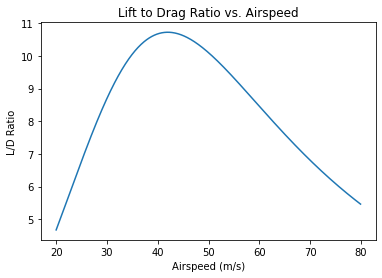

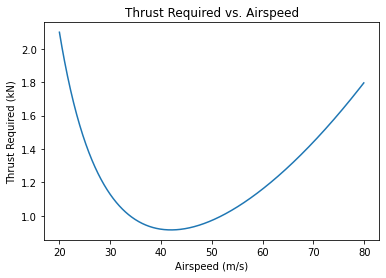

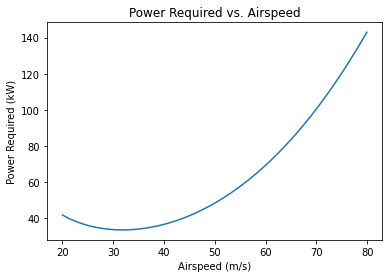

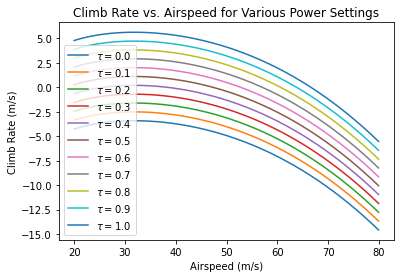

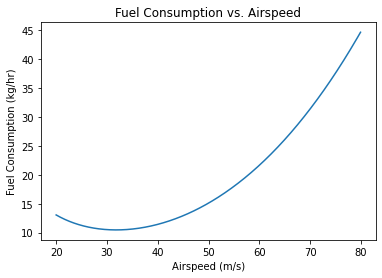

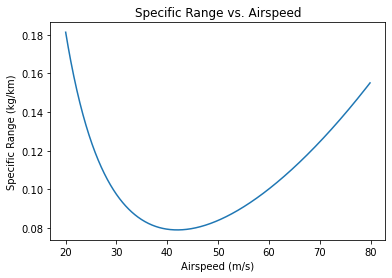

In [11]:
# Calculate Stall Speeds
(v_min_nf, v_min_f) = stall_speeds(w, s_w, rho, c_lmax_nf, c_lmax_f)

# Calculate the Lift to Drag Ratios
(v, lod) = lift_to_drag(alpha_t, w, s_w, rho, c_d0, c_d0l, e, ar)

# Calculate the Thrust Required
(t_r) = thrust_required(w, v, lod)

# Calculate the Power Required
(p_r) = power_required(t_r, v, alpha_t)

# Calculate the climb rate with various power settings
climb_rate(rho_0, rho, p_a0, p_r, w, v)

# Calculate the specific fuel consumption
(q) = fuel_consumption(p_r, v, q_p)

# Calculate the specific range
specific_range(q, v)

# Draw all the plots
plt.show()